In [2]:
%cd Vietnamese/

/mnt/1A7C64A87C647FFD/Machine Learning/Projects/ALPR/Character-Time-series-Matching/Vietnamese


In [3]:
import sys
import os
sys.path.append(os.path.abspath('../yolov5'))
from models.experimental import attempt_load

In [4]:
def load_model(path, train = False):
    # print(self.device)
    model = attempt_load(path, map_location='cpu')  # load FP32 model
    names = model.module.names if hasattr(model, 'module') else model.names  # get class names
    if train:
        model.train()
    else:
        model.eval()
    return model, names

In [5]:
char_model, names = load_model('char.pt')

char.pt


Fusing layers... 
Model Summary: 181 layers, 1214114 parameters, 0 gradients, 3.5 GFLOPs


In [4]:
# ! pip install -r requirement.txt

  Using cached imutils-0.5.4.tar.gz (17 kB)
  Preparing metadata (setup.py) ... done
  Using cached joblib-1.1.0-py2.py3-none-any.whl (306 kB)
  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/08/73/a4af3493a81d6e5e1fdb4c72f4d3573a7e94b60f7c2c69ab0275fdc7cd8e/matplotlib-3.7.3-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 1.5 MB/s eta 0:00:00m eta 0:00:010:00:01
  Using cached oauthlib-3.2.0-py3-none-any.whl (151 kB)
  Using cached opencv_python-4.5.5.64-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (60.5 MB)
  Using cached packaging-21.3-py3-none-any.whl (40 kB)
  Obtaining dependency information for pandas from https://files.pythonhosted.org/packages/f8/7f/5b047effafbdd34e52c9e2d7e44f729a0655efafb22198c45cf692cdc157/pandas-2.0.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for scikit-learn from ht

In [6]:
# %pip install pyyaml

  Obtaining dependency information for pyyaml from https://files.pythonhosted.org/packages/c8/6b/6600ac24725c7388255b2f5add93f91e58a5d7efaf4af244fdbcc11a541b/PyYAML-6.0.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 736.6/736.6 kB 2.4 MB/s eta 0:00:002.5 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
!python evaluate.py 

Fusing layers... 
Model Summary: 181 layers, 1213854 parameters, 0 gradients, 3.6 GFLOPs
Fusing layers... 
Model Summary: 181 layers, 1213854 parameters, 0 gradients, 3.6 GFLOPs
100%|███████████████████████████████████████████| 60/60 [00:53<00:00,  1.11it/s]
0.9666666666666667
case fail ['track0107', 'track0136']


In [2]:
# %cd Vietnamese/
# !python DETECTION.py --weights char.pt --imgsz 128 --conf 0.25 

In [3]:
# !python DETECTION.py --weights object.pt --imgsz 128

In [1]:
%cd Vietnamese/

/mnt/1A7C64A87C647FFD/Machine Learning/Projects/ALPR/Character-Time-series-Matching/Vietnamese


In [5]:
!python DETECTION2.py --obj-weights object.pt --char-weights char.pt --imgsz 640 --conf 0.25 

object.pt
Fusing layers... 
Model Summary: 213 layers, 7039792 parameters, 0 gradients, 15.9 GFLOPs
char.pt
Fusing layers... 
Model Summary: 181 layers, 1214114 parameters, 0 gradients, 3.6 GFLOPs


In [2]:
%cd Vietnamese/

/mnt/1A7C64A87C647FFD/Machine Learning/Projects/ALPR/Character-Time-series-Matching/Vietnamese


In [132]:
cropped_image.shape[:2][::-1]

(361, 85)

In [10]:
import numpy as np
import torch
import os
import sys
import argparse
sys.path.append(os.path.abspath('../yolov5'))
from utils.general import non_max_suppression, scale_coords
# from ai_core.object_detection.yolov5_custom.od.data.datasets import letterbox
from typing import List
# from dynaconf import settings
from models.experimental import attempt_load
import cv2

/home/ali/anaconda3/envs/alpr/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
class Detection:
    def __init__(self, weights_path='.pt',size=(640,640),device='cpu',iou_thres=0.5,conf_thres=0.25):
        # cwd = os.path.dirname(__file__)
        self.device=device
        self.char_model, self.names = self.load_model(weights_path)
        self.size=size
        
        self.iou_thres=iou_thres
        self.conf_thres=conf_thres

    def detect(self, frame):
        
        results, resized_img = self.char_detection_yolo(frame)

        return results, resized_img
    
    def preprocess_image(self, original_image):

        resized_img = self.ResizeImg(original_image,size=self.size)
        # resized_img = original_image.copy()
        image = resized_img.copy()[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB, to 3x416x416
        image = np.ascontiguousarray(image)

        image = torch.from_numpy(image).to(self.device)
        image = image.float()
        image = image / 255.0
        if image.ndimension() == 3:
            image = image.unsqueeze(0)
        return image, resized_img
    
    def char_detection_yolo(self, image, classes=None, \
                            agnostic_nms=True, max_det=1000):

        img,resized_img = self.preprocess_image(image.copy())
        pred = self.char_model(img, augment=False)[0]
        
        detections = non_max_suppression(pred, conf_thres=self.conf_thres,
                                            iou_thres=self.iou_thres,
                                            classes=classes,
                                            agnostic=agnostic_nms,
                                            multi_label=True,
                                            labels=(),
                                            max_det=max_det)
        results=[]
        for i, det in enumerate(detections):
            # det[:, :4]=scale_coords(resized_img.shape,det[:, :4],image.shape).round()
            det=det.tolist()
            if len(det):
                for *xyxy, conf, cls in det:
                    # xc,yc,w_,h_=(xyxy[0]+xyxy[2])/2,(xyxy[1]+xyxy[3])/2,(xyxy[2]-xyxy[0]),(xyxy[3]-xyxy[1])
                    result=[self.names[int(cls)], str(conf), (xyxy[0],xyxy[1],xyxy[2],xyxy[3])]
                    results.append(result)
        # print(results)
        return results, resized_img
        
    def ResizeImg(self, img, size):
        h1, w1, _ = img.shape
        # print(h1, w1, _)
        h, w = size
        if w1 < h1 * (w / h):
            # print(w1/h1)
            img_rs = cv2.resize(img, (int(float(w1 / h1) * h), h))
            mask = np.zeros((h, w - (int(float(w1 / h1) * h)), 3), np.uint8)
            img = cv2.hconcat([img_rs, mask])
            trans_x = int(w / 2) - int(int(float(w1 / h1) * h) / 2)
            trans_y = 0
            trans_m = np.float32([[1, 0, trans_x], [0, 1, trans_y]])
            height, width = img.shape[:2]
            img = cv2.warpAffine(img, trans_m, (width, height))
            return img
        else:
            img_rs = cv2.resize(img, (w, int(float(h1 / w1) * w)))
            mask = np.zeros((h - int(float(h1 / w1) * w), w, 3), np.uint8)
            img = cv2.vconcat([img_rs, mask])
            trans_x = 0
            trans_y = int(h / 2) - int(int(float(h1 / w1) * w) / 2)
            trans_m = np.float32([[1, 0, trans_x], [0, 1, trans_y]])
            height, width = img.shape[:2]
            img = cv2.warpAffine(img, trans_m, (width, height))
            return img
    def load_model(self,path, train = False):
        # print(self.device)
        model = attempt_load(path, map_location=self.device)  # load FP32 model
        names = model.module.names if hasattr(model, 'module') else model.names  # get class names
        if train:
            model.train()
        else:
            model.eval()
        return model, names
    def xyxytoxywh(self, x):
        # Convert nx4 boxes from [x1, y1, x2, y2] to [x, y, w, h] where xy1=top-left, xy2=bottom-right
        y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
        y[0] = (x[0] + x[2]) / 2  # x center
        y[1] = (x[1] + x[3]) / 2  # y center
        y[2] = x[2] - x[0]  # width
        y[3] = x[3] - x[1]  # height
        return y
    

In [30]:
#!python DETECTION2.py --obj-weights object.pt --char-weights char.pt --imgsz 640 --conf 0.25
obj_model=Detection(size=(640,640), weights_path='object.pt')
char_model=Detection(size=(128,128), weights_path='char.pt')

Fusing layers... 


Model Summary: 213 layers, 7039792 parameters, 0 gradients, 15.9 GFLOPs
Fusing layers... 
Model Summary: 181 layers, 1214114 parameters, 0 gradients, 3.6 GFLOPs


In [41]:
img=cv2.imread(os.path.join('img','car.jpeg'))
%matplotlib inline

(498, 616, 3)


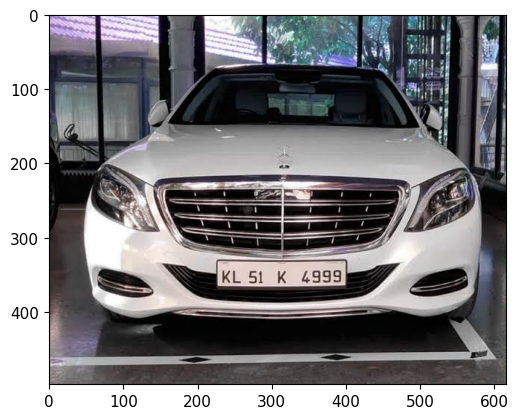

In [20]:
import matplotlib.pyplot as plt
print(img.shape)
plt.imshow(img)
plt.show()

In [34]:
def detect2(self, image, classes=None, \
                            agnostic_nms=True, max_det=1000):

    img,resized_img = self.preprocess_image(image.copy())
    pred = self.char_model(img, augment=False)[0]
    
    detections = non_max_suppression(pred, conf_thres=self.conf_thres,
                                        iou_thres=self.iou_thres,
                                        classes=classes,
                                        agnostic=agnostic_nms,
                                        multi_label=True,
                                        labels=(),
                                        max_det=max_det)
    results=[]
    for i, det in enumerate(detections):
        # det[:, :4]=scale_coords(resized_img.shape,det[:, :4],image.shape).round()
        det=det.tolist()
        if len(det):
            for *xyxy, conf, cls in det:
                # xc,yc,w_,h_=(xyxy[0]+xyxy[2])/2,(xyxy[1]+xyxy[3])/2,(xyxy[2]-xyxy[0]),(xyxy[3]-xyxy[1])
                result=[self.names[int(cls)], str(conf), (xyxy[0],xyxy[1],xyxy[2],xyxy[3])]
                results.append(result)
    # print(results)
    return results, resized_img

In [54]:
img=cv2.imread(os.path.join('img','car.jpeg'))

In [55]:
# results, resized_img=detect2(obj_model, img.copy())
# timeit.timeit('detect2(obj_model, img.copy())', number=1000)
img,resized_img = obj_model.preprocess_image(img.copy())

In [56]:
obj_model.char_model(img, augment=False)[0]

tensor([[[4.90127e+00, 3.63231e+00, 1.23752e+01,  ..., 9.33821e-03, 8.51367e-03, 1.72728e-02],
         [1.07134e+01, 3.58371e+00, 1.77576e+01,  ..., 1.26680e-02, 1.10869e-02, 1.41390e-02],
         [1.93960e+01, 3.67692e+00, 1.79526e+01,  ..., 1.25845e-02, 1.17136e-02, 1.03184e-02],
         ...,
         [5.62755e+02, 6.15011e+02, 1.73911e+02,  ..., 3.01786e-02, 3.98742e-02, 4.47448e-02],
         [5.79749e+02, 6.15089e+02, 1.45666e+02,  ..., 2.88215e-02, 4.20666e-02, 4.49940e-02],
         [6.13947e+02, 6.16972e+02, 1.50438e+02,  ..., 3.99308e-02, 6.12722e-02, 6.50030e-02]]])

In [24]:
# results, resized_img=obj_model.detect(img.copy())

In [114]:
# results, resized_img=obj_model.detect(img.copy())
for name,conf,box in results:
    resized_img=cv2.putText(resized_img, "{}".format(name), (int(box[0]), int(box[1])-3),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                            (255, 0, 255), 2)
    resized_img = cv2.rectangle(resized_img, (int(box[0]),int(box[1])), (int(box[2]),int(box[3])), (0,0,255), 1)
    if(name=='rectangle license plate'):
        # Crop the image using the ROI coordinates
        cropped_image = resized_img[int(box[1]):int(box[3]), int(box[0]):int(box[2])]
        x1,y1,x2,y2 = int(box[0]),int(box[1]),int(box[2]),int(box[3])
#         cv2.imwrite(os.path.join('out','cropped_license_plate.jpg'), cropped_image)
# if not os.path.exists(os.path.join('out')):
#     os.makedirs(os.path.join('out'))
# cv2.imwrite(os.path.join('out','car.jpeg'),resized_img)

True

In [115]:
%matplotlib inline

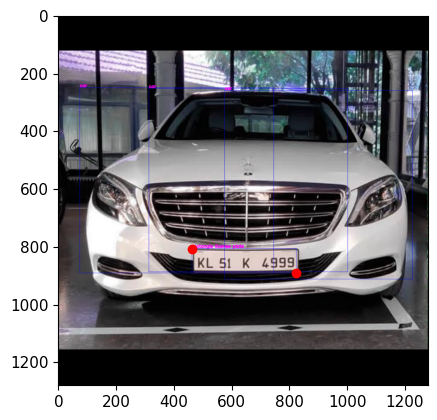

In [116]:
plt.imshow(resized_img)
plt.plot(x1,y1, 'ro')
plt.plot(x2,y2, 'ro')
plt.show()

In [117]:
cropped_image.shape

(85, 361, 3)

In [57]:
%conda list

# packages in environment at /home/ali/anaconda3/envs/alpr:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                        main  
_openmp_mutex             5.1                       1_gnu  
absl-py                   1.4.0                    pypi_0    pypi
asttokens                 2.4.0              pyhd8ed1ab_0    conda-forge
backcall                  0.2.0              pyh9f0ad1d_0    conda-forge
backports                 1.0                pyhd8ed1ab_3    conda-forge
backports.functools_lru_cache 1.6.5              pyhd8ed1ab_0    conda-forge
bzip2                     1.0.8                h7b6447c_0  
ca-certificates           2023.08.22           h06a4308_0  
cachetools                5.3.1                    pypi_0    pypi
certifi                   2023.7.22                pypi_0    pypi
charset-normalizer        3.2.0                    pypi_0    pypi
comm                      0.1.4              pyhd8ed1ab_0    conda-forg

In [122]:
def crop_with_argwhere(image):
    # Mask of non-black pixels (assuming image has a single channel).
    mask = image > 0
    
    # Coordinates of non-black pixels.
    coords = np.argwhere(mask)
    
    # Bounding box of non-black pixels.
    x0, y0 = coords.min(axis=0)
    x1, y1 = coords.max(axis=0) + 1   # slices are exclusive at the top
    
    # Get the contents of the bounding box.
    cropped = image[x0:x1, y0:y1]
    return x0,y0,x1,y1

def crop_rgb_with_argwhere(image):
    # Split the RGB image into its individual channels (R, G, B).
    r_channel, g_channel, b_channel = cv2.split(image)
    
    # Apply the cropping function to each channel.
    x0,y0,x1,y1 = crop_with_argwhere(r_channel)
    r_cropped = r_channel[x0:x1, y0:y1]
    g_cropped = g_channel[x0:x1, y0:y1]
    b_cropped = b_channel[x0:x1, y0:y1]

    
    # Merge the cropped channels back into an RGB image.
    cropped_rgb_image = cv2.merge((r_cropped, g_cropped, b_cropped))
    
    return cropped_rgb_image


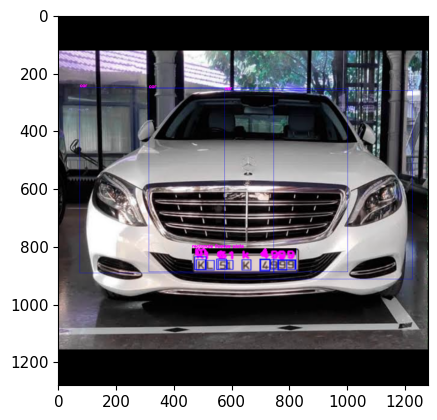

In [123]:
results2, resized_img2=char_model.detect(cropped_image.copy())
for name,conf,box in results2:
    resized_img2=cv2.putText(resized_img2, "{}".format(name), (int(box[0]), int(box[1])-3),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                            (255, 0, 255), 2)
    resized_img2 = cv2.rectangle(resized_img2, (int(box[0]),int(box[1])), (int(box[2]),int(box[3])), (0,0,255), 1)
    # x1_ch,y1_ch,x2_ch,y2_ch = int(box[0]),int(box[1]),int(box[2]),int(box[3])

# if not os.path.exists(os.path.join('out')):
#     os.makedirs(os.path.join('out'))
# cv2.imwrite(os.path.join('out',img_name),resized_img)
resized_img[y1:y2, x1:x2] = cv2.resize(crop_rgb_with_argwhere(resized_img2),(361,85))
plt.imshow(resized_img)
plt.show()

In [144]:
resized_img.shape

(1280, 1280, 3)

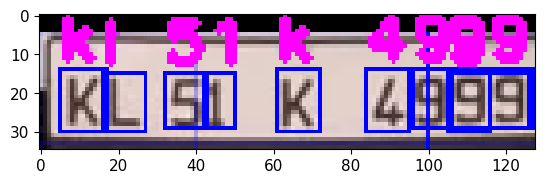

In [120]:
def crop_with_argwhere(image):
    # Mask of non-black pixels (assuming image has a single channel).
    mask = image > 0
    
    # Coordinates of non-black pixels.
    coords = np.argwhere(mask)
    
    # Bounding box of non-black pixels.
    x0, y0 = coords.min(axis=0)
    x1, y1 = coords.max(axis=0) + 1   # slices are exclusive at the top
    
    # Get the contents of the bounding box.
    cropped = image[x0:x1, y0:y1]
    return x0,y0,x1,y1

def crop_rgb_with_argwhere(image):
    # Split the RGB image into its individual channels (R, G, B).
    r_channel, g_channel, b_channel = cv2.split(image)
    
    # Apply the cropping function to each channel.
    x0,y0,x1,y1 = crop_with_argwhere(r_channel)
    r_cropped = r_channel[x0:x1, y0:y1]
    g_cropped = g_channel[x0:x1, y0:y1]
    b_cropped = b_channel[x0:x1, y0:y1]

    
    # Merge the cropped channels back into an RGB image.
    cropped_rgb_image = cv2.merge((r_cropped, g_cropped, b_cropped))
    
    return cropped_rgb_image

plt.imshow(crop_rgb_with_argwhere(resized_img2))

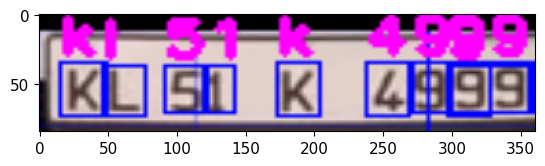

In [111]:
plt.imshow(cv2.resize(crop_rgb_with_argwhere(resized_img2),(361,85)))
# crop_with_argwhere(cv2.cvtColor(resized_img2, cv2.COLOR_BGR2GRAY))

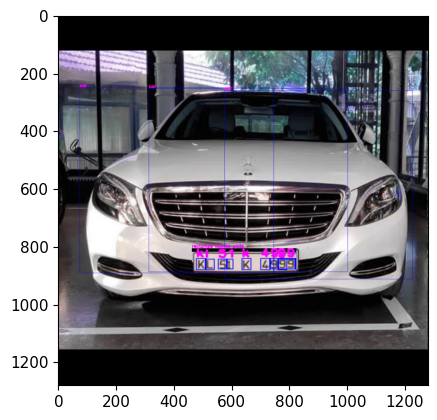

In [121]:
resized_img[y1:y2, x1:x2] = cv2.resize(crop_rgb_with_argwhere(resized_img2),(361,85))
plt.imshow(resized_img)

In [16]:
cropped_image.shape, resized_img2.shape, resized_img.shape

((85, 361, 3), (128, 128, 3), (1280, 1280, 3))

In [45]:
def ReverseResize(img, original_shape):
    # Get the original image's height and width
    h1, w1, _ = original_shape

    # Extract the height and width of the resized image
    h, w, _ = img.shape

    # Calculate the scaling factors for width and height
    scale_x = w1 / w
    scale_y = h1 / h

    # Reverse the translation to center the image
    trans_x = int((w - w1) / 2)
    trans_y = int((h - h1) / 2)
    trans_m = np.float32([[1, 0, -trans_x], [0, 1, -trans_y]])
    img = cv2.warpAffine(img, trans_m, (w, h))

    # Reverse the resizing operation
    if scale_x < scale_y:
        # Resize vertically
        img = cv2.resize(img, (w1, int(h1 * scale_x)))
    else:
        # Resize horizontally
        img = cv2.resize(img, (int(w1 * scale_y), h1))

    return img

In [53]:
resized_img2.shape

(128, 128, 3)

In [54]:
ReverseResize(resized_img2, (85,361,3)).shape

(85, 239, 3)

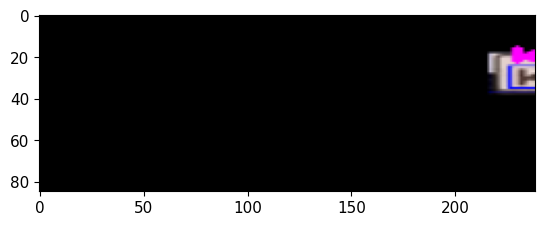

In [55]:
plt.imshow(ReverseResize(resized_img2, (85,361,3)))
plt.show()

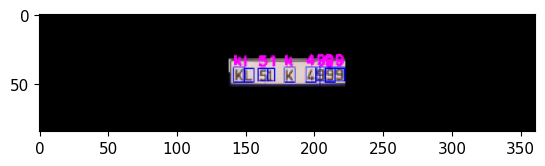

In [56]:
cropped_image2 = char_model.ResizeImg(resized_img2.copy(),(85,361))
# resized_img[y1:y2, x1:x2] = cropped_image2
plt.imshow(cropped_image2)
# plt.xlim(135,230)
# plt.ylim(55,25)
plt.show()

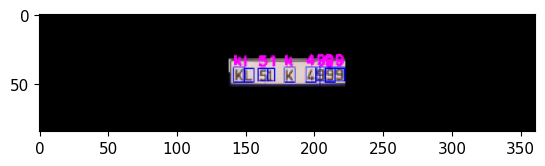

In [36]:
plt.imshow(resized_img[y1:y2, x1:x2])
plt.show()

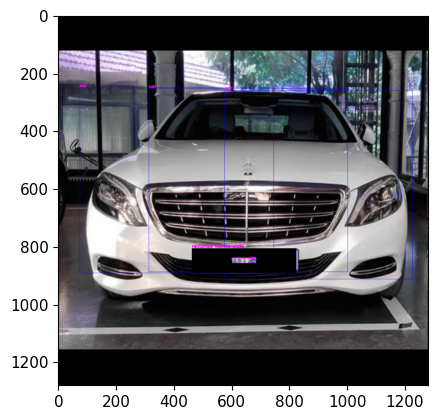

In [38]:
resized_img[y1:y2, x1:x2] = cropped_image
plt.imshow(resized_img)
plt.show()

In [83]:
resized_img2.shape, cropped_image.shape

((128, 128, 3), (85, 361, 3))

In [84]:
image1 = resized_img2.copy()
image2 = cropped_image.copy()
x_scale = image2.shape[1] / image1.shape[1]
y_scale = image2.shape[0] / image1.shape[0]
x_scale, y_scale

(2.8203125, 0.6640625)

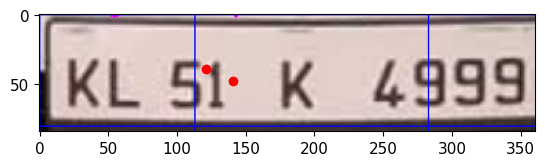

In [82]:
# Apply scaling factors to map to image2
x1_image2 = int(x1_ch * x_scale)
y1_image2 = int(y1_ch * y_scale)
x2_image2 = int(x2_ch * x_scale)
y2_image2 = int(y2_ch * y_scale)

# Draw the bounding box on image2
# cv2.rectangle(image2, (x1_image2, y1_image2), (x2_image2, y2_image2), (0, 255, 0), 2)  # Green rectangle
# cv2.imshow('Image2 with Bounding Boxes', image2)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
plt.imshow(image2)
# plt.imshow(image2)
plt.plot(x1_image2,y1_image2, 'ro')
plt.plot(x2_image2,y2_image2, 'ro')
# plt.show()

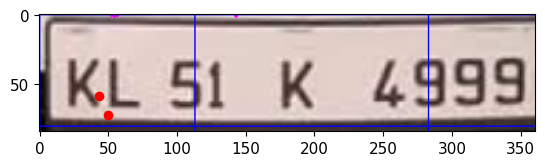

In [29]:
plt.imshow(cropped_image)
plt.plot(x1_ch,y1_ch, 'ro')
plt.plot(x2_ch,y2_ch, 'ro')
plt.show()

In [ ]:
import time

if __name__ == '__main__':
    opt = parse_opt()
    
    # Open camera 
    cap = cv2.VideoCapture(0)
    start = time.time_ns()
    frame_count = 0
    fps = -1
    
    # Save video
    frame_width = int(cap.get(3))
    frame_height = int(cap.get(4))
    
    size = (frame_width, frame_height)
    video = cv2.VideoWriter('./static/results/face-recognition2.mp4',cv2.VideoWriter_fourcc(*'mp4v'), 6, size)

    
    char_model=Detection(size=opt.imgsz,weights_path=opt.weights,device=opt.device,iou_thres=opt.iou_thres,conf_thres=opt.conf_thres)
    path=opt.source

    img_names=os.listdir(path)

    for img_name in img_names:
        img=cv2.imread(os.path.join(path,img_name))
        results, resized_img=char_model.detect(img.copy())
        for name,conf,box in results:
            resized_img=cv2.putText(resized_img, "{}".format(name), (int(box[0]), int(box[1])-3),
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                                    (255, 0, 255), 2)
            resized_img = cv2.rectangle(resized_img, (int(box[0]),int(box[1])), (int(box[2]),int(box[3])), (0,0,255), 1)
        if not os.path.exists(os.path.join('out')):
            os.makedirs(os.path.join('out'))
        cv2.imwrite(os.path.join('out',img_name),resized_img)

In [11]:
import time 

# Open camera 
cap = cv2.VideoCapture(0)
start = time.time_ns()
frame_count = 0
fps = -1

[ WARN:0@2626.583] global /io/opencv/modules/videoio/src/cap_v4l.cpp (889) open VIDEOIO(V4L2:/dev/video0): can't open camera by index
